# **Import packages**

In [1]:
# !pip install yellowbrick

In [22]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from yellowbrick.target import FeatureCorrelation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import warnings
warnings.filterwarnings(action='ignore')

# **Data**

In [3]:
train = pd.read_csv("../DAT/train.csv")
test = pd.read_csv("../DAT/test.csv")
train = train.drop(['ID'], axis=1)
test = test.drop(['ID'], axis=1)
print(train.shape, test.shape)

(2207, 183) (2208, 182)


In [4]:
train.head(3)

,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,692,275.0,287.0,292.0,289.5,2.8,2.8,2.7,2.7,2.7,...,70.978249,70.876794,70.705253,70.559603,70.427356,70.340491,70.293830,70.262422,70.169841,70.043251
1,534,293.0,284.0,336.0,310.0,3.3,3.3,3.3,3.2,3.2,...,71.535483,71.382303,71.253604,71.092665,70.955608,70.796630,70.597550,70.565088,70.560502,70.427600
2,634,300.0,392.0,450.0,421.0,3.0,2.9,2.9,2.9,2.9,...,71.279804,71.199570,71.144020,71.026740,70.920038,70.876723,70.710129,70.595971,70.418203,70.399578


In [5]:
print("train null count: %d개 " % (train.isnull().sum().sum()))
print("test null count: %d개 " % (test.isnull().sum().sum()))

train null count: 0개 
test null count: 0개 


In [6]:
target = list(["착과량(int)"])
state = train.columns[1:5].to_list()
sprout = train.filter(regex = "새순").columns.to_list()
chla = train.filter(regex = "엽록소").columns.to_list()
print(len(target), len(state), len(sprout), len(chla))

1 4 89 89


# **파생변수 생성**

## **_범주형 변수 생성**

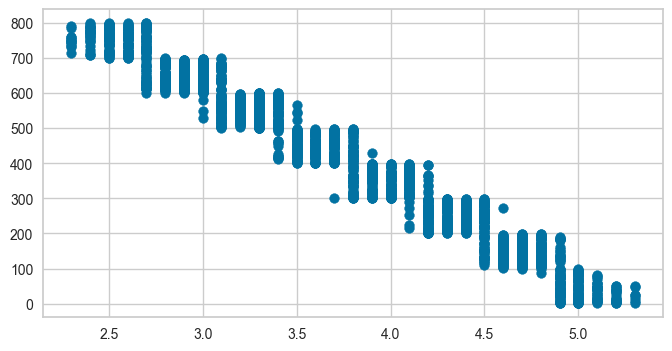

In [7]:
plt.figure(figsize = (8, 4))
plt.scatter(train["2022-09-01 새순"], train[target]);

In [8]:
### 첫 날 새순 크기에 따른 범주형 변수 생성
    # 착과량 범위가 큰 기준으로 분할
value_range = {}
for value_ in train[sprout[0]].unique():
    range_ = train[train[sprout[0]] == value_][target].max() - train[train[sprout[0]] == value_][target].min()
    value_range[value_] = range_[0]

In [9]:
cond_base = sorted(dict(sorted(value_range.items(), key = lambda item: item[1], reverse = True)[:7]).keys())

In [10]:
def sprout_cat_(cond):
    cond_list = [(cond_base[0] < cond) & (cond <= cond_base[1]), 
                 (cond_base[1] < cond) & (cond <= cond_base[2]), 
                 (cond_base[2] < cond) & (cond <= cond_base[3]), 
                 (cond_base[3] < cond) & (cond <= cond_base[4]), 
                 (cond_base[4] < cond) & (cond <= cond_base[5]), 
                 (cond_base[5] < cond) & (cond <= cond_base[6]), 
                 (cond_base[6] < cond)]

    sprout_cat = np.select(cond_list, list(range(1,8)), 0)
    return sprout_cat

In [11]:
train["sprout_cat"] = sprout_cat_(train[sprout[0]].values)
test["sprout_cat"] = sprout_cat_(test[sprout[0]].values)

## **_연속형 변수 생성**

In [12]:
train["sprout_diff"] = train[sprout].iloc[:, 0] - train[sprout].iloc[:, -1]
train["sprout_mean"] = train[sprout].mean(axis = 1)
train["chla_diff"] = train[chla].iloc[:, 0] - train[chla].iloc[:, -1]
train["chla_mean"] = train[chla].mean(axis = 1)
train["diff_ratio"] = train["chla_diff"] / train["sprout_diff"]
train["vol"] = train["수고(m)"] * train["수관폭1(min)"] * train["수관폭2(max)"]
train["ratio1"] = train["2022-09-01 새순"] / train["chla_mean"]
train["ratio2"] = train["2022-09-01 새순"] / train["vol"]

test["sprout_diff"] = test[sprout].mean(axis = 1)
test["sprout_mean"] = test[sprout].mean(axis = 1)
test["chla_diff"] = test[chla].iloc[:, 0] - test[chla].iloc[:, -1]
test["chla_mean"] = test[chla].mean(axis = 1)
test["diff_ratio"] = test["chla_diff"] / test["sprout_diff"]
test["vol"] = test["수고(m)"] * test["수관폭1(min)"] * test["수관폭2(max)"]
test["ratio1"] = test["2022-09-01 새순"] / test["chla_mean"]
test["ratio2"] = test["2022-09-01 새순"] / test["vol"]

In [138]:
print(train.shape, test.shape)

(2207, 192) (2208, 191)


# **Train/Valid split**

In [13]:
train_X, valid_X, train_y, valid_y = train_test_split(train.drop(columns = target), train[target], 
                                                      test_size = 0.3, shuffle = True, random_state = 717)

train_X = train_X.reset_index(drop = True)
train_y = train_y.reset_index(drop = True)
valid_X = valid_X.reset_index(drop = True)
valid_y = valid_y.reset_index(drop = True)

print(train_X.shape, valid_X.shape, train_y.shape, valid_y.shape)

(1544, 191) (663, 191) (1544, 1) (663, 1)


# **Preprocessing: PLS**

In [131]:
def pls_X(train_X, valid_X, train_y, comp = 20):
    ### 표준화
    std = StandardScaler().fit(train_X)
    st_train_X = pd.DataFrame(std.transform(train_X), columns = train_X.columns)
    st_valid_X = pd.DataFrame(std.transform(valid_X), columns = valid_X.columns)
    std_y = (train_y - train_y.mean())/train_y.std()

    comp = 20
    ### Sprout PLS
    pls_sprout = PLSRegression(n_components = comp).fit(st_train_X[sprout], std_y)
    tr_pls_sprout_df = pd.DataFrame(pls_sprout.transform(st_train_X[sprout]), columns = ["sprout pls" + str(i+1) for i in range(comp)])
    vd_pls_sprout_df = pd.DataFrame(pls_sprout.transform(st_valid_X[sprout]), columns = ["sprout pls" + str(i+1) for i in range(comp)])
    # display(tr_pls_sprout_df.head(3))

    ### Chla PLS
    pls_chla = PLSRegression(n_components = comp).fit(st_train_X[chla], std_y)
    tr_pls_chla_df = pd.DataFrame(pls_chla.transform(st_train_X[chla]), columns = ["chla pls" + str(i+1) for i in range(comp)])
    vd_pls_chla_df = pd.DataFrame(pls_chla.transform(st_valid_X[chla]), columns = ["chla pls" + str(i+1) for i in range(comp)])
    # display(tr_pls_chla_df.head(3))
    
    train_X_pls = pd.concat([st_train_X, tr_pls_sprout_df, tr_pls_chla_df], axis = 1)
    valid_X_pls = pd.concat([st_valid_X, vd_pls_sprout_df, vd_pls_chla_df], axis = 1)
    # print(train_X_pls.shape, valid_X_pls.shape)
    
    return train_X_pls, valid_X_pls

In [132]:
train_X_pls, valid_X_pls = pls_X(train_X, valid_X, train_y)

In [133]:
# display(train_X_pls.head(3), valid_X_pls.head(3))

# **Modeling**

## **_Evalutaion metric: NMAE**

In [134]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

## **_Models**

In [135]:
SEED = 717
model_dict = {}
model_dict["RF"] = RandomForestRegressor(random_state = SEED)
model_dict["ET"] = ExtraTreesRegressor(random_state = SEED)
model_dict["LGBM"] = LGBMRegressor(random_state = SEED)
model_dict["XGB"] = XGBRegressor(random_state = SEED)
model_dict["GB"] = GradientBoostingRegressor(random_state = SEED)
model_dict["CAT"] = CatBoostRegressor(random_state = SEED, silent = True, loss_function = "MAE")

## **_Fit and Predict**

In [23]:
pred_dict = {}
for name_, model_ in tqdm(model_dict.items()):
    start_time = time.time()
    model_fit = model_.fit(train_X_pls, train_y)
    pred = model_fit.predict(valid_X_pls)
    pred_dict[name_] = pred
    print("%s NMAE: %.4f| 소요시간: %.4fsec"% (name_, NMAE(np.ravel(valid_y), np.ravel(pred)), time.time()-start_time))

  0%|          | 0/6 [00:00<?, ?it/s]

RF NMAE: 0.0745| 소요시간: 62.0074sec
ET NMAE: 0.0755| 소요시간: 14.8877sec
LGBM NMAE: 0.0784| 소요시간: 1.3515sec
XGB NMAE: 0.0798| 소요시간: 3.4773sec
GB NMAE: 0.0756| 소요시간: 27.2161sec
CAT NMAE: 0.0790| 소요시간: 34.1596sec


## **_Ensemble results**

In [126]:
def ensemble_result(pred_dict, true_y = valid_y, ascending = True):
    import itertools

    ensemble_df = pd.DataFrame()
    arr_name = pred_dict.keys()
    arr_value = pred_dict.values()

    for i in range(1, len(arr_name)+1):
        ncr_name = list(itertools.combinations(arr_name, i))
        ncr_value = list(itertools.combinations(arr_value, i))
        for j in range(len(ncr_name)):
            pred_ens = np.mean(list(ncr_value[j]), axis = 0)       
            ens_NMAE = NMAE(np.ravel(true_y), pred_ens)
            ensemble_df[ncr_name[j]] = [np.round(ens_NMAE, 4)]


    ensemble_df.index = ["result"]
    ensemble_df = ensemble_df.T.sort_values(by = "result", ascending = ascending)
    return ensemble_df

In [128]:
ensemble_df = ensemble_result(pred_dict)
ensemble_df.head(3)

,result
"(RF, ET, GB)",0.0741
"(RF, GB)",0.0744
"(RF, ET)",0.0744


# **Test**

## **_Test predict**

In [137]:
Train_X = train.drop(columns = target)
Train_y = train[target]
print(Train_X.shape, Train_y.shape)

(2207, 191) (2207, 1)


In [140]:
Train_X_pls, test_pls = pls_X(Train_X, test, Train_y)
print(Train_X_pls.shape, test_pls.shape)

(2207, 231) (2208, 231)


In [149]:
Pred_list = []
for model_name in ensemble_df.index[0]:
    model_fit = model_dict[model_name].fit(Train_X_pls, Train_y)
    pred = model_fit.predict(test_pls)
    Pred_list.append(pred)   

In [150]:
Final_pred = np.mean(Pred_list, axis = 0)
print(ensemble_df.index[0], Final_pred) 

('RF', 'ET', 'GB') [254.70382268 758.8458665  169.85515944 ... 368.92318109 248.1709331
 112.10309388]


## **_Submission**

In [151]:
sample_submission = pd.read_csv('../DAT/sample_submission.csv')

In [152]:
sample_submission['착과량(int)'] = Final_pred

In [153]:
sample_submission.head()

,ID,착과량(int)
0,TEST_0000,254.703823
1,TEST_0001,758.845866
2,TEST_0002,169.855159
3,TEST_0003,466.593385
4,TEST_0004,685.768679


In [178]:
# sample_submission.to_csv("../OUT/"+ str(datetime.today())[:10] + " final.csv", index = False)